Import Libraries

In [293]:
import os
import msoffcrypto
import pandas as pd
import numpy as np
from datetime import datetime as dt
from matplotlib import pyplot as plt
from scipy.interpolate import CubicSpline
from sklearn.linear_model import LinearRegression
import pmdarima as pm
from pmdarima import model_selection
import math
import pytz
import datetime

In [294]:
xls = pd.ExcelFile("RawData9.xlsx")
Factor_data = pd.read_excel(xls,'Factor')
Gold_data = pd.read_excel(xls,'GoldBar_Sale')

In [295]:
factor_col = Factor_data.columns[1:]

In [296]:
factor_col

Index(['(Inflation)', 'PTT_แก๊สโซฮอล์_95', 'PTT_แก๊สโซฮอล์_91',
       'PTT_แก๊สโซฮอล์_E20', 'PTT_แก๊สโซฮอล์_E85', 'PTT_ดีเซล',
       'อัตราแลกเปลี่ยน_USD_THB', 'BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)',
       'US_Dollar_Index', 'S&P_500_Index', 'MSTF_Index',
       'SCB_ออมทรัพย์(อัตราดอกเบี้ย)', 'SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)',
       'SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)', 'SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)',
       'SCB_ประจำ_24_เดือน(อัตราดอกเบี้ย)', 'Manufacturing (GDP)', 'SET Index',
       'XAU_USD', 'เงินสำรองระหว่างประเทศ (ทอง)'],
      dtype='object')

In [297]:
Gold_Factor_data = \
                pd.merge(
                    Gold_data,
                    Factor_data,
                    left_on = 'Report Date',
                    right_on = 'Report Date',
                    how = 'left'
                )

In [298]:
Gold_Factor_data.replace([np.inf, -np.inf],np.nan,inplace=True)
Gold_Factor_data = Gold_Factor_data.dropna(axis='columns')

In [299]:
Gold_Factor_data['LOGIT'] = np.log(Gold_Factor_data['GoldBar_Sale'].values)
Gold_Factor_data['LOGIT'].replace([np.inf, -np.inf, np.nan],0,inplace=True)

C:\Users\temp5\AppData\Local\Temp\ipykernel_10480\3363949668.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Gold_Factor_data['LOGIT'].replace([np.inf, -np.inf, np.nan],0,inplace=True)


In [300]:
Gold_Factor_data['LOGIT']

0       9.888374
1       9.920836
2       9.920836
3       9.982761
4       9.998798
         ...    
151    10.373491
152    10.393600
153    10.439981
154    10.422281
155    10.423768
Name: LOGIT, Length: 156, dtype: float64

เลือกตัวแปรที่สนใจ และเกี่ยวข้องกับทองคำ

In [320]:
import statsmodels.api as sm
from statsmodels.compat import lzip
from statsmodels.tsa.stattools import adfuller
main_Factor_list = factor_col
# Factor_list = Gold_Factor_data.drop(columns = ['GoldBar_Sale'] ).columns
# Factor_list = Gold_Factor_data.drop(columns = ['Report Date','GoldBar_Sale','LOGIT']).columns
Factor_list = Gold_Factor_data.drop(columns = ['Report Date','GoldBar_Sale','LOGIT']).columns
All_result_table = pd.DataFrame()
All_result_table_best = pd.DataFrame()

for ix , temp_factor_group in enumerate(main_Factor_list,1):
    Factor_group = [i for i in Factor_list if temp_factor_group in i]
    r2_list = []
    # print(ix , " " , temp_factor_group , " " , Factor_group)
    # print(Factor_group)
    temp_result_table = pd.DataFrame()
    for temp_factor in Factor_group:
        X_train = np.array(Gold_Factor_data[temp_factor].values , dtype=float)
        y_train = np.array(Gold_Factor_data['LOGIT'].values , dtype=float)
        # y_train = np.array(Gold_Factor_data['GoldBar_Sale'].values , dtype=float)
        
        X_train_1 = X_train.reshape(-1,1)
        y_train_1 = y_train.reshape(-1,1)

        # test stationary test 10%
        adf = adfuller(X_train)[1]
        adf_result = 'PASS' if adfuller(X_train)[1] <= 0.4 else 'FAIL'

        #Regression
        linear_model = LinearRegression()
        linear_model.fit(X_train_1 , y_train_1)

        X_train = sm.add_constant(X_train)
        reg = sm.OLS(y_train , X_train).fit()
        sign = '+' if linear_model.coef_ > 0 else '-'

        r2_list.append((temp_factor,reg.rsquared,sign,adf,adf_result))
        # print(r2_list)

    temp_result_table['Factor'] = np.array(r2_list)[:,0]
    temp_result_table['r2'] = np.array(r2_list)[:,1]
    temp_result_table['sign'] = np.array(r2_list)[:,2]
    temp_result_table['adf'] = np.array(r2_list)[:,3]
    temp_result_table['adf_result'] = np.array(r2_list)[:,4]

    temp_result_table_sort = temp_result_table.sort_values(['adf_result','r2'], ascending = [False,False]).reset_index(drop=True)

    if ix == 1:
        All_result_table = temp_result_table
        # All_result_table_best = temp_result_table_sort.head(1)
    else:
        All_result_table = pd.concat([All_result_table,temp_result_table], ignore_index = True)
        # All_result_table_best = pd.concat([All_result_table,temp_result_table_sort.head(1)], ignore_index = True)
All_result_table

,Factor,r2,sign,adf,adf_result
0,(Inflation),0.05187151977125404,+,0.384208513196113,PASS
1,PTT_แก๊สโซฮอล์_95,0.044115003563566124,+,0.4433370559392254,FAIL
2,PTT_แก๊สโซฮอล์_91,0.07204126215161144,+,0.3605919027180712,PASS
3,PTT_แก๊สโซฮอล์_E20,0.10302827721838437,+,0.40180837828112953,FAIL
4,PTT_แก๊สโซฮอล์_E85,0.39077137276660845,+,0.7169152371016783,FAIL
5,PTT_ดีเซล,0.11012031033264236,+,0.23800627119664364,PASS
6,อัตราแลกเปลี่ยน_USD_THB,0.025285339130852957,+,0.2056790383161553,PASS
7,BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย),0.05229840324851365,-,0.08872752547000201,PASS
8,US_Dollar_Index,0.10084020834562368,+,0.5042493483773777,FAIL
9,S&P_500_Index,0.4578906751165499,+,0.9811630268910562,FAIL


In [302]:
Factor_list

Index(['(Inflation)', 'PTT_แก๊สโซฮอล์_95', 'PTT_แก๊สโซฮอล์_91',
       'PTT_แก๊สโซฮอล์_E20', 'PTT_แก๊สโซฮอล์_E85', 'PTT_ดีเซล',
       'อัตราแลกเปลี่ยน_USD_THB', 'BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)',
       'US_Dollar_Index', 'S&P_500_Index', 'MSTF_Index',
       'SCB_ออมทรัพย์(อัตราดอกเบี้ย)', 'SCB_ประจำ_3_เดือน(อัตราดอกเบี้ย)',
       'SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย)', 'SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย)',
       'SCB_ประจำ_24_เดือน(อัตราดอกเบี้ย)', 'Manufacturing (GDP)', 'SET Index',
       'XAU_USD', 'เงินสำรองระหว่างประเทศ (ทอง)'],
      dtype='object')

In [303]:
Pass_Factor_list = All_result_table[All_result_table['adf_result'] == 'PASS']
Pass_Factor_list.to_excel("ADF_RESULT_PASS.xlsx")

In [304]:
Pass_Factor_list = Pass_Factor_list['Factor']

Overall Model Performance

In [310]:
from itertools import combinations
comb_list = [i for i in combinations(Pass_Factor_list , 7)] + [i for i in combinations(Pass_Factor_list, 6)]
# comb_list = [i for i in combinations(Pass_Factor_list , 6)]

In [315]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import anderson as AD
from statsmodels.stats.outliers_influence import variance_inflation_factor

all_stats_results = pd.DataFrame()

# y_train = np.array(Gold_Factor_data['GoldBar_Sale'].values , dtype=float)
y_train = np.array(Gold_Factor_data['LOGIT'].values , dtype=float)

for out_index , comb in enumerate(comb_list,1):
    selected_Factor = list(comb)
    X_train = np.array(Gold_Factor_data[selected_Factor].values , dtype = float)

    linear_model = LinearRegression()
    linear_model.fit(X_train , y_train)

    X_train = sm.add_constant(X_train)
    reg = sm.OLS(y_train , X_train).fit()

    X_train = X_train[:,1:]
    y_pred = linear_model.predict(X_train)

    stats_results = pd.DataFrame()
    stats_results[[f'FACTOR_{i+1}' for i in range(len(selected_Factor))]] = np.array([selected_Factor])

    coeff_result = reg.summary2().tables[1].iloc[:,:1].transpose().reset_index(drop=True)
    for i in ['const','x1','x2','x3','x4','x5','x6','x7']:
        if i in coeff_result.columns:
            stats_results[i] = coeff_result[i]
        else:
            stats_results[i] = None
    # P-Value
    stats_results[['intercept_p_value'] + [f'FACTOR_{i+1}_p_value' for i in range(len(selected_Factor))]] = reg.pvalues
    # ADJ Rsq
    r2 = r2_score(y_train,y_pred)
    n , p = X_train.shape
    adj_r2 = 1 - (( 1 - r2 ) * (n - 1) / (n - p - 1))
    stats_results['r2'] = r2
    stats_results['adj_r2'] = adj_r2
    # F stats
    stats_results['Probability of F-Stats'] = reg.summary2().tables[0][3].astype(float)[5]
    # Anderson Darling
    stats_results['AD'] = AD(reg.resid , dist='norm')[0]
    stats_results['AD_criteria'] = [{i:j for i , j in zip(AD( reg.resid , dist='norm')[2],
                                                         AD( reg.resid , dist='norm')[1]
                                                         )}]
    stats_results['AD_criteria_0.05'] = AD( reg.resid , dist='norm')[1][2:3]
    # Breusch-Pagan
    name_stats = ['Lagrange multiplier statistic','p-value','f-value','f p-value']
    test = sm.stats.het_breuschpagan(reg.resid , reg.model.exog )
    stats_results['BP_pvalues'] = lzip(name_stats , test )[1][1]
    # Durbin Watson
    stats_results['Durbin_Watson'] = sm.stats.durbin_watson(reg.resid)
    # VIF 
    VIF_values = [variance_inflation_factor(Gold_Factor_data[selected_Factor].values , i) for i in range(len(selected_Factor))]

    for in_index , i in enumerate(selected_Factor , 0 ):
        stats_results[f'VIF_Factor_{in_index+1}'] = VIF_values[in_index]
    if out_index == 1:
        all_stats_results = stats_results
    else:
        all_stats_results = pd.concat([all_stats_results, stats_results], axis = 0).reset_index(drop=True)
all_stats_results = all_stats_results.sort_values('adj_r2', ascending = False)

C:\Users\temp5\AppData\Local\Temp\ipykernel_10480\3761393146.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_stats_results = pd.concat([all_stats_results, stats_results], axis = 0).reset_index(drop=True)
C:\Users\temp5\AppData\Local\Temp\ipykernel_10480\3761393146.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_stats_results = pd.concat([all_stats_results, stats_results], axis = 0).reset_index(drop=True)
C:\Users\temp5\AppData\Local\Temp\ipykernel_10480\3761393146.py:63: Future

In [316]:
Pass_Stat_list = all_stats_results

In [329]:
#Adj Stats in factor to interesting
Pass_Stat_list = all_stats_results[all_stats_results['r2'] >= 0.55]
Pass_Stat_list = all_stats_results[all_stats_results['adj_r2'] >= 0.59]
Pass_Stat_list = Pass_Stat_list[Pass_Stat_list['Probability of F-Stats'] <= 0.5]
# Pass_Stat_list = Pass_Stat_list[Pass_Stat_list['AD'] < Pass_Stat_list['AD_criteria_0.05']]
# Pass_Stat_list = Pass_Stat_list[Pass_Stat_list['BP_pvalues'] > 0.05]
# Pass_Stat_list = Pass_Stat_list[Pass_Stat_list['Durbin_Watson'] >= 1]
# Pass_Stat_list = Pass_Stat_list[Pass_Stat_list['VIF_Factor_1'] <= 5]
# Pass_Stat_list = Pass_Stat_list[Pass_Stat_list['VIF_Factor_2'] <= 5]
# Pass_Stat_list = Pass_Stat_list[(Pass_Stat_list['VIF_Factor_3'] <= 5 | (Pass_Stat_list['VIF_Factor_3'].isna()))]

In [330]:
# Pass_Stat_list['adj_r2'].max()
# Pass_Stat_list[Pass_Stat_list['adj_r2'].values == Pass_Stat_list['adj_r2'].max()]
# Pass_Stat_list.describe()
# Pass_Stat_list.info()
Pass_Stat_list[['FACTOR_1','FACTOR_2','FACTOR_3','FACTOR_4','FACTOR_5','FACTOR_6','FACTOR_7','const','x1','x2','x3','x4','x5','x6','x7','r2','adj_r2','Probability of F-Stats']]
# Pass_Stat_list[['FACTOR_1','FACTOR_2','FACTOR_3','FACTOR_4','FACTOR_5','FACTOR_6','const','x1','x2','x3','x4','x5','x6','r2','adj_r2','Probability of F-Stats']]
# Pass_Stat_list[['FACTOR_1','FACTOR_2','FACTOR_3','FACTOR_4','FACTOR_5','const','x1','x2','x3','x4','x5','r2','adj_r2','Probability of F-Stats']]
# Pass_Stat_list[['FACTOR_1','FACTOR_2','FACTOR_3','const','x1','x2','x3','r2','adj_r2','Probability of F-Stats']]
# Pass_Stat_list[['FACTOR_1','FACTOR_2','FACTOR_3','FACTOR_4','const','x1','x2','x3','x4','r2','adj_r2','Probability of F-Stats']]

,FACTOR_1,FACTOR_2,FACTOR_3,FACTOR_4,FACTOR_5,FACTOR_6,FACTOR_7,const,x1,x2,x3,x4,x5,x6,x7,r2,adj_r2,Probability of F-Stats
102,(Inflation),PTT_แก๊สโซฮอล์_91,อัตราแลกเปลี่ยน_USD_THB,SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย),SCB_ประจำ_24_เดือน(อัตราดอกเบี้ย),SET Index,XAU_USD,11.072333,0.067360,0.017937,-0.008589,-0.840048,6.475967e-01,-0.000322,-0.000487,0.616003,0.597841,7.950000e-28
67,(Inflation),PTT_แก๊สโซฮอล์_91,PTT_ดีเซล,SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย),SCB_ประจำ_24_เดือน(อัตราดอกเบี้ย),SET Index,XAU_USD,10.723496,0.046981,0.013295,0.011642,-0.738290,5.585864e-01,-0.000406,-0.000465,0.615785,0.597612,8.280000e-28
117,(Inflation),PTT_แก๊สโซฮอล์_91,BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย),SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย),SCB_ประจำ_24_เดือน(อัตราดอกเบี้ย),SET Index,XAU_USD,10.801534,0.056348,0.018426,0.106300,-0.771341,4.832579e-01,-0.000359,-0.000467,0.614665,0.596440,1.020000e-27
453,(Inflation),PTT_แก๊สโซฮอล์_91,SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย),SCB_ประจำ_24_เดือน(อัตราดอกเบี้ย),SET Index,XAU_USD,NaN,10.793644,0.061161,0.018290,-0.795995,0.612552,-3.423393e-04,-0.000475,NaN,0.609177,0.593439,4.370000e-28
122,(Inflation),PTT_แก๊สโซฮอล์_91,SCB_ประจำ_6_เดือน(อัตราดอกเบี้ย),SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย),SCB_ประจำ_24_เดือน(อัตราดอกเบี้ย),SET Index,XAU_USD,10.838967,0.060955,0.018354,-0.118838,-0.668324,5.799902e-01,-0.000374,-0.000468,0.610584,0.592166,2.190000e-27
125,(Inflation),PTT_แก๊สโซฮอล์_91,SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย),SCB_ประจำ_24_เดือน(อัตราดอกเบี้ย),Manufacturing (GDP),SET Index,XAU_USD,10.927709,0.060238,0.018586,-0.805115,0.617796,-2.262592e-07,-0.000321,-0.000485,0.609837,0.591383,2.520000e-27
257,PTT_แก๊สโซฮอล์_91,PTT_ดีเซล,BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย),SCB_ประจำ_12_เดือน(อัตราดอกเบี้ย),SCB_ประจำ_24_เดือน(อัตราดอกเบี้ย),SET Index,XAU_USD,10.623724,0.011602,0.019917,0.143411,-0.641232,3.206453e-01,-0.000487,-0.000400,0.609123,0.590635,2.880000e-27


In [198]:
# Factor_interested = ['PTT ดีเซล','BOT Policy rate (อัตราดอกเบี้ย นโยบาย)','SCB ประจำ 6 เดือน','SET Index']
Factor_interested = ['PTT_แก๊สโซฮอล์_91','PTT_ดีเซล','BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)','SCB_ประจำ_6_เดือน','SET Index']
# Factor_value = [10.298575,0.023988,0.125921,-0.402924,-0.000441]
Factor_value = [29497.530115,145.269999,380.901024,3784.104396,-10974.702639,-9.751643]


Version 2

In [199]:
# Gold_Factor_data[['LOGIT']+Factor_interested].corr()
Gold_Factor_data[['GoldBar_Sale']+Factor_interested].corr()

,GoldBar_Sale,PTT_แก๊สโซฮอล์_91,PTT_ดีเซล,BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย),SCB_ประจำ_6_เดือน,SET Index
GoldBar_Sale,1.000000,0.283323,0.347587,-0.231068,-0.374327,-0.028973
PTT_แก๊สโซฮอล์_91,0.283323,1.000000,0.884291,0.485205,0.391628,-0.106258
PTT_ดีเซล,0.347587,0.884291,1.000000,0.348132,0.230083,0.083744
BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย),-0.231068,0.485205,0.348132,1.000000,0.955061,-0.536653
SCB_ประจำ_6_เดือน,-0.374327,0.391628,0.230083,0.955061,1.000000,-0.550413
SET Index,-0.028973,-0.106258,0.083744,-0.536653,-0.550413,1.000000


Text(0, 0.5, 'Gold Price')

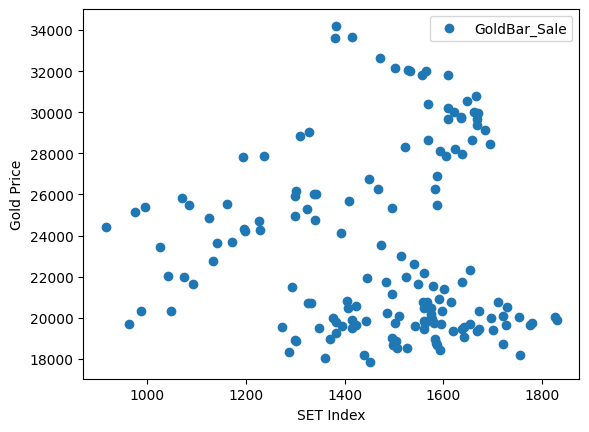

In [200]:
Gold_Factor_data.plot(x='SET Index',y='GoldBar_Sale',style='o')
plt.ylabel('Gold Price')

In [107]:
from sklearn.linear_model import LinearRegression


In [108]:
X = Gold_Factor_data[['SET Index']]
y = Gold_Factor_data[['GoldBar_Sale']]

In [110]:
# y = ax + b
lrm = LinearRegression()
lrm.fit(X,y)

LinearRegression()

In [112]:
lrm.intercept_ # b

array([24235.28824981])

In [113]:
lrm.coef_ # a

array([[-0.63096352]])

In [115]:
predictions = lrm.predict(X)
predictions

array([[23626.97631974],
       [23611.95307832],
       [23574.36658141],
       [23545.29178239],
       [23557.74069265],
       [23578.15236253],
       [23520.07217047],
       [23560.12573475],
       [23657.19316274],
       [23620.25655825],
       [23607.271329  ],
       [23588.34873302],
       [23551.34272255],
       [23502.80269892],
       [23480.17003744],
       [23460.15587457],
       [23515.04339122],
       [23495.72959786],
       [23478.57369973],
       [23460.79314773],
       [23415.79913908],
       [23415.748662  ],
       [23399.86731019],
       [23357.03119679],
       [23305.12182796],
       [23262.60750595],
       [23250.31633658],
       [23227.09687902],
       [23249.67906342],
       [23319.19231447],
       [23337.33882532],
       [23418.63216529],
       [23362.56474686],
       [23324.88360542],
       [23370.15523802],
       [23415.84961617],
       [23431.26405497],
       [23399.05336725],
       [23366.91839516],
       [23342.51272618],


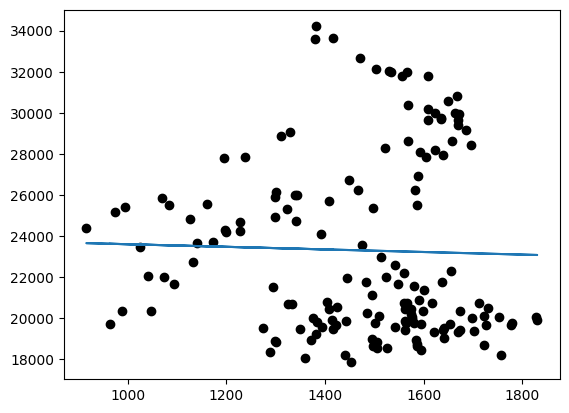

In [117]:
plt.scatter(X,y,color='black')
plt.plot(X,predictions)

In [118]:
from sklearn import metrics
metrics.mean_absolute_error(y,predictions)

3748.0622724134987

In [119]:
Gold_Factor_data[['GoldBar_Sale']+Factor_interested].corr()

,GoldBar_Sale,PTT ดีเซล,BOT Policy rate (อัตราดอกเบี้ย นโยบาย),SCB ประจำ 6 เดือน,SET Index
GoldBar_Sale,1.000000,0.347587,-0.231068,-0.374327,-0.028973
PTT ดีเซล,0.347587,1.000000,0.348132,0.230083,0.083744
BOT Policy rate (อัตราดอกเบี้ย นโยบาย),-0.231068,0.348132,1.000000,0.955061,-0.536653
SCB ประจำ 6 เดือน,-0.374327,0.230083,0.955061,1.000000,-0.550413
SET Index,-0.028973,0.083744,-0.536653,-0.550413,1.000000


In [201]:
from sklearn.linear_model import LinearRegression
X = Gold_Factor_data[Factor_interested]
y = np.log(Gold_Factor_data[['GoldBar_Sale']])

In [202]:
lrm = LinearRegression()
lrm.fit(X,y)

LinearRegression()

In [203]:
predictions = lrm.predict(X)
np.exp(predictions)

array([[28468.78365904],
       [29254.83169434],
       [27522.02213917],
       [25834.75336374],
       [25888.63671466],
       [25474.95988867],
       [23840.4789445 ],
       [21551.3870148 ],
       [22966.58143986],
       [22704.14696467],
       [21806.48576168],
       [21717.15147486],
       [21758.94155279],
       [21914.32802089],
       [21869.75536248],
       [21295.56940793],
       [21134.80404201],
       [20571.09620157],
       [20598.5907687 ],
       [20449.06465938],
       [19719.13213913],
       [20267.93666012],
       [21395.50546448],
       [20784.04155343],
       [20066.43323808],
       [19824.07175922],
       [19516.46081671],
       [19034.83245363],
       [18800.98263964],
       [19793.49658006],
       [20145.961482  ],
       [21223.37322234],
       [20363.33583274],
       [19831.15350141],
       [21172.47520267],
       [22409.63657597],
       [23592.01800043],
       [24048.88752523],
       [25260.57596345],
       [24956.04952958],


In [204]:
from sklearn import metrics
metrics.mean_absolute_error(y,predictions) # MAE

0.10076931942715496

In [205]:
lrm.score(X,y) # R-Square

0.5202319804435628

In [206]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [207]:
X = Gold_Factor_data[Factor_interested]
y = (Gold_Factor_data[['GoldBar_Sale']])

In [214]:
model = sm.OLS(y,X)

In [215]:
# model.params # ceof
result = model.fit()
result.params 

PTT_แก๊สโซฮอล์_91                          -35.943928
PTT_ดีเซล                                 1016.360844
BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)    1856.910190
SCB_ประจำ_6_เดือน                        -5914.436080
SET Index                                    0.006704
dtype: float64

In [216]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           GoldBar_Sale   R-squared (uncentered):                   0.974
Model:                            OLS   Adj. R-squared (uncentered):              0.973
Method:                 Least Squares   F-statistic:                              1139.
Date:                Mon, 15 Jul 2024   Prob (F-statistic):                   6.19e-118
Time:                        11:02:14   Log-Likelihood:                         -1507.6
No. Observations:                 156   AIC:                                      3025.
Df Residuals:                     151   BIC:                                      3040.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
PTT_แก๊สโซฮอล์_91                        -35.9439    131.340     -0.274      0.785    -295.446     223.558
PTT_ดีเซล                               1016.3608    196.952      5.160      0.000     627.224    1405.497
BOT_Policy_rate_(อัตราดอกเบี้ย นโยบาย)  1856.9102   1459.215      1.273      0.205   -1026.205    4740.025
SCB_ประจำ_6_เดือน                      -5914.4361   1887.816     -3.133      0.002   -9644.382   -2184.491
SET Index                                  0.0067      1.569      0.004      0.997      -3.093       3.106
==============================================================================
Omnibus:                        5.466   Durbin-Watson:                   0.178
Prob(Omnibus):                  0.065   Jarque-Bera (JB):                5.142
Skew:                           0.385   Prob(JB):                       0.0765
Kurtosis:                       2.556   Cond. No.                     1.13e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Plot Graph

       ! Gold_data -> File


<Axes: >

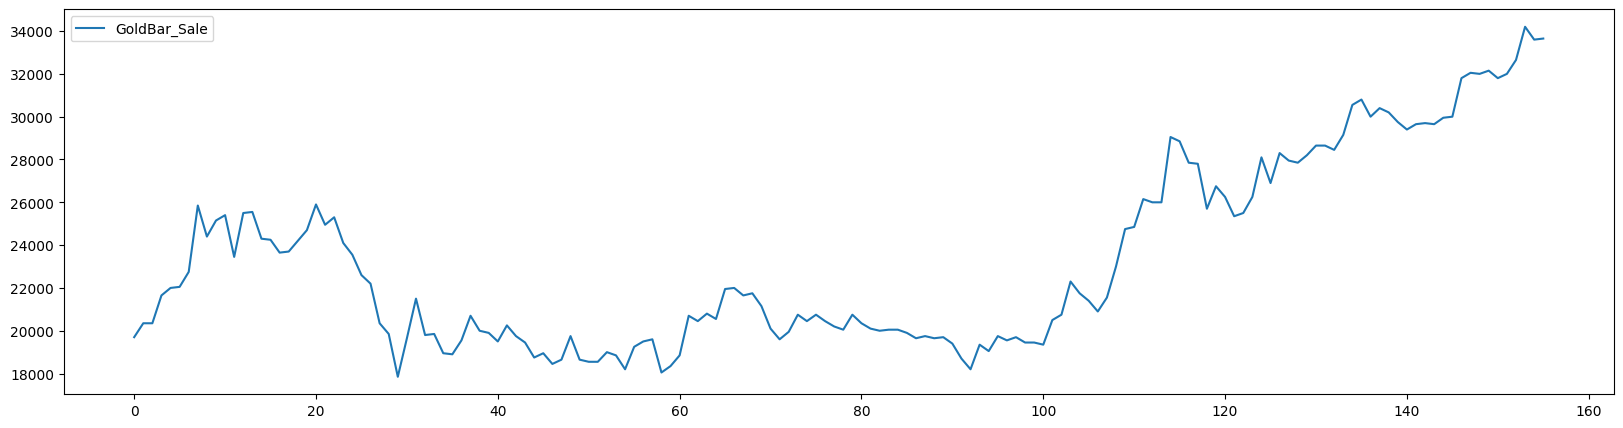

In [51]:
Gold_data['GoldBar_Sale'].plot(figsize = (20,5) , legend = True)

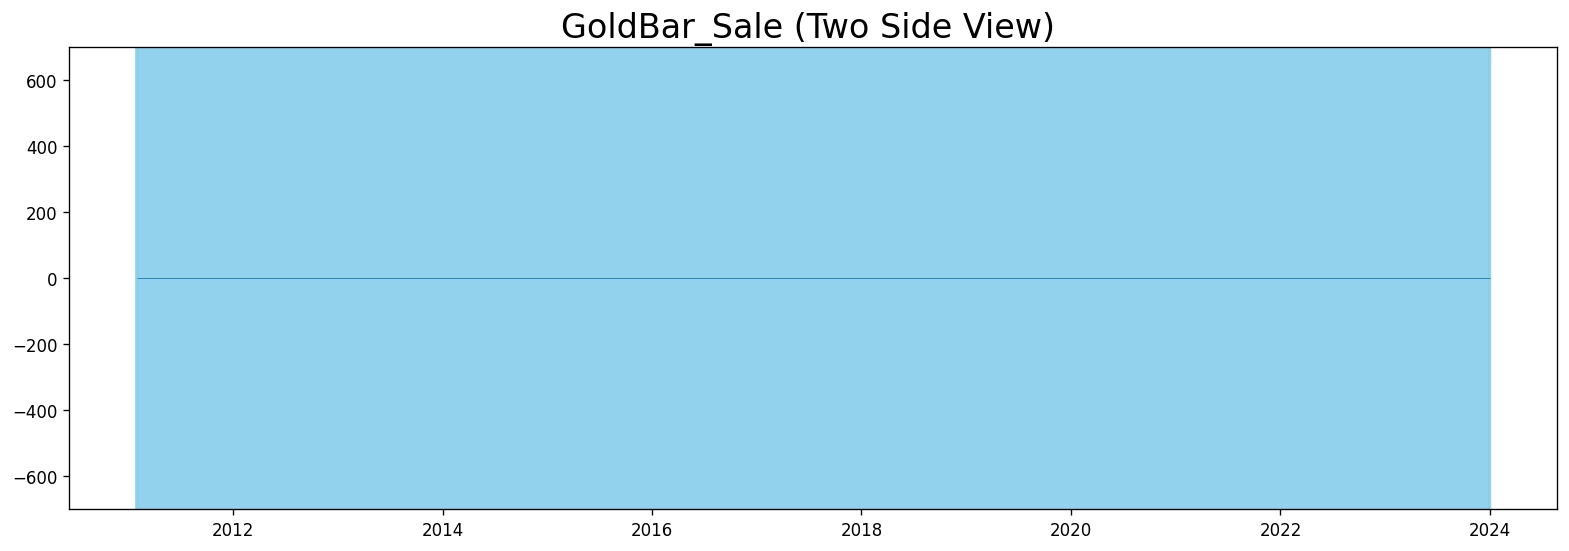

In [73]:
#Plot Two Side View
fig , ax = plt.subplots(1,1,figsize=(16,5) , dpi=120)
x = Gold_data['Report Date'].values

y1 = Gold_data['GoldBar_Sale'].values

plt.fill_between( x , y1 = y1 , y2 = -y1 , alpha=0.9 , linewidth=2, color='skyblue')

plt.ylim(-700 , 700 )
plt.title('GoldBar_Sale (Two Side View) ' , fontsize = 20)

plt.hlines( y=0 , xmin = np.min(Gold_data['Report Date']) , xmax = np.max(Gold_data['Report Date']) , linewidth=0.5)

plt.show()

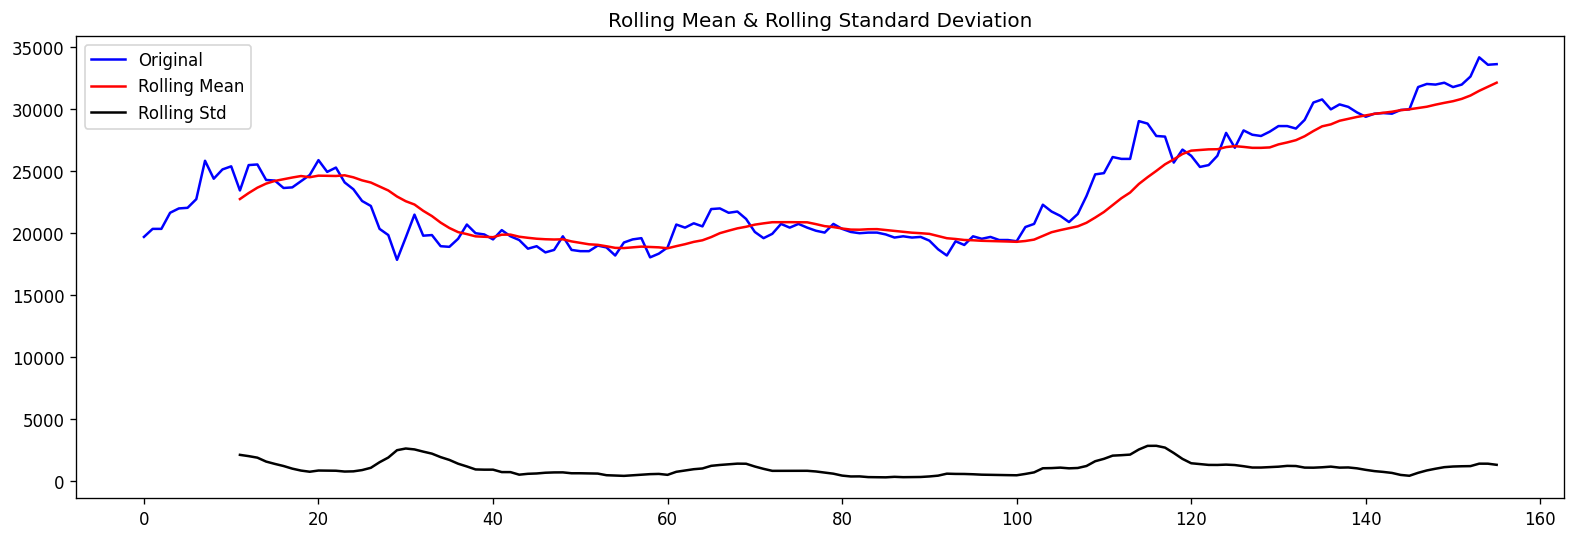

In [69]:
#ทดสอบ Stationary
rolling_mean = Gold_data['GoldBar_Sale'].rolling(window = 12).mean()
rolling_std = Gold_data['GoldBar_Sale'].rolling(window = 12).std()
fig , ax = plt.subplots(1,1,figsize=(16,5),dpi = 120)
plt.plot(Gold_data['GoldBar_Sale'],color = 'blue',label = 'Original')
plt.plot(rolling_mean , color = 'red' , label = 'Rolling Mean')
plt.plot(rolling_std , color = 'black' , label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

In [68]:
result = adfuller(Gold_data['GoldBar_Sale'])
print('ADF Statistic : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('Critical Values:')
for key , value in result[4].items():
    print('\t{}: {}'.format(key,value))

ADF Statistic : -0.25132470546380203
p-value : 0.9321208869747761
Critical Values:
	1%: -3.4732590518613002
	5%: -2.880374082105334
	10%: -2.5768120811654525


In [86]:
# function
def get_stationarity(timeseries):
    rolling_mean = timeseries.rolling(window = 12).mean()
    rolling_std = timeseries.rolling(window = 12).std()
    original = plt.plot(timeseries, color = 'blue' , label ='Original')
    mean = plt.plot(rolling_mean , color = 'red' , label = 'Rolling Mean')
    std = plt.plot(rolling_std , color = 'black' , label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block =False)
    # Dickey-Fuller Test
    result = adfuller(timeseries)
    print('ADF Statiestic: {} '.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key , value in result[4].items():
        print('\t{} : {}'.format(key,value))

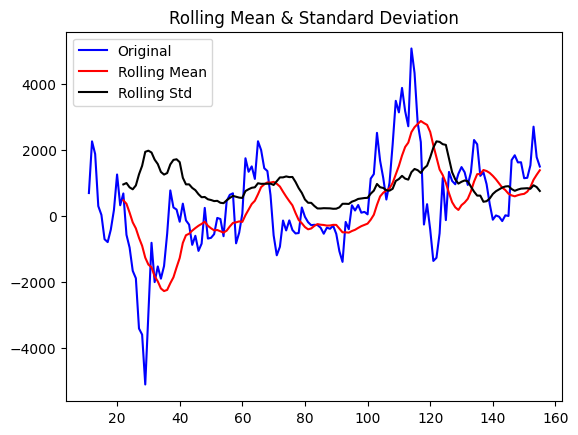

ADF Statiestic: -3.3308983120231344 
p-value: 0.013552562125553171
Critical Values:
	1% : -3.476597917537401
	5% : -2.8818291230495543
	10% : -2.5775887982253085


In [87]:
# วิธีแรกในการปรับข้อมูลให้เรียบคือ การลบด้วยค่าเฉลี่ยเคลื่อนที่ 12 เดือนย้อนหลังออกไป เพื่อกำจัด ฤดูกาลกับแนวโน้ม
rolling_mean = Gold_data['GoldBar_Sale'].rolling(window=12).mean()
df_log_minus_mean = Gold_data['GoldBar_Sale'] - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

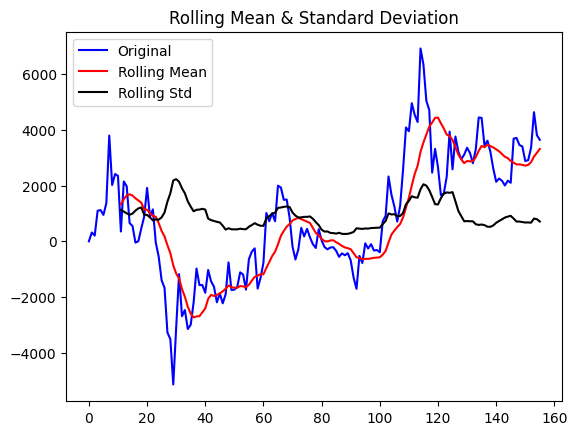

ADF Statiestic: -2.206766739159659 
p-value: 0.20379869426954533
Critical Values:
	1% : -3.4732590518613002
	5% : -2.880374082105334
	10% : -2.5768120811654525


In [88]:
# p value ต่ำแล้ว ลองวิธี take log
rolling_mean_exp_decay = Gold_data['GoldBar_Sale'].ewm(halflife=12,min_periods=0,adjust=True).mean()

df_log_exp_decay = Gold_data['GoldBar_Sale'] - rolling_mean_exp_decay
df_log_exp_decay.dropna(inplace = True)
get_stationarity(df_log_exp_decay)

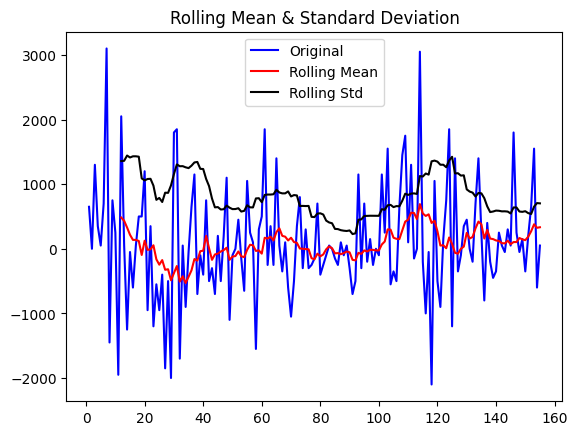

ADF Statiestic: -13.656836430155131 
p-value: 1.5480057912548305e-25
Critical Values:
	1% : -3.473542528196209
	5% : -2.880497674144038
	10% : -2.576878053634677


In [89]:
# วิธีลบด้วยค่าก่อนหน้า
df_log_shift = Gold_data['GoldBar_Sale'] - Gold_data['GoldBar_Sale'].shift()
df_log_shift.dropna(inplace = True)
get_stationarity(df_log_shift)

สร้าง ARIMA Model

In [118]:
# import libaries
from dateutil.parser import parse
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pmdarima as pm
from pmdarima import model_selection
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
import joblib
import os

In [122]:
# 1,1,2 ARIMA Model
model = pm.ARIMA(order=(1,1,2),seasonal=False)
model_fit = model.fit(Gold_data['GoldBar_Sale'],disp=0)
print(model_fit.summary())

C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  156
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -1269.331
Date:                Thu, 11 Jul 2024   AIC                           2548.662
Time:                        12:09:21   BIC                           2563.879
Sample:                             0   HQIC                          2554.843
                                - 156                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     72.3140    263.937      0.274      0.784    -444.993     589.621
ar.L1          0.2731      2.607      0.105      0.917      -4.837       5.383
ma.L1         -0.3123      2.600     -0.120      0.9

In [123]:
# 1,1,1 ARIMA Model
model = pm.ARIMA(order=(1,1,1),seasonal=False)
model_fit = model.fit(Gold_data['GoldBar_Sale'],disp=0)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  156
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1269.381
Date:                Thu, 11 Jul 2024   AIC                           2546.762
Time:                        12:11:00   BIC                           2558.936
Sample:                             0   HQIC                          2551.707
                                - 156                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     87.9640    196.459      0.448      0.654    -297.089     473.017
ar.L1          0.0038      1.992      0.002      0.998      -3.901       3.909
ma.L1         -0.0408      1.986     -0.021      0.9

C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


C:\Users\temp5\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


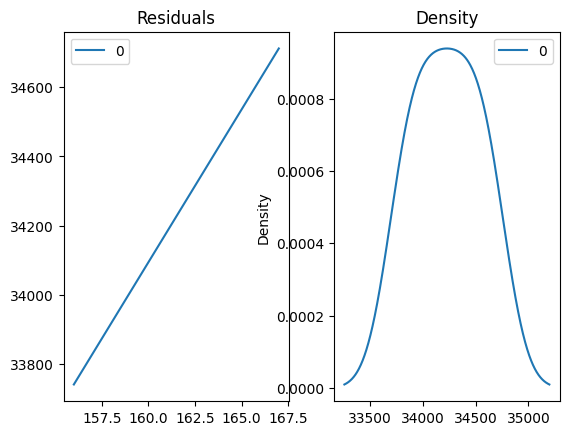

In [135]:
# เลือกอันที่ P > |Z| ดีๆ คือค่าน้อยๆ
preds, conf_int = model_fit.predict(n_periods=12, return_conf_int=True)
residuals = pd.DataFrame(preds)
fig,ax = plt.subplots(1,2)
residuals.plot(title="Residuals",ax=ax[0])
residuals.plot(kind='kde',title='Density',ax=ax[1])
plt.show()

ARIMA MODEL pmdarima 

In [230]:
arima = pm.auto_arima(Gold_data['GoldBar_Sale'], start_p=1, start_q=1, max_p=12, max_q=5, max_order = 12,
                     trace=False, suppress_warnings=True, stepwise = True,
                     error_action='ignore', m=12)
period_predict = 10
preds, conf_int = arima.predict(n_periods=12*period_predict, return_conf_int=True)
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  156
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -1267.587
Date:                              Thu, 11 Jul 2024   AIC                           2541.174
Time:                                      13:57:38   BIC                           2550.304
Sample:                                           0   HQIC                          2544.882
                                              - 156                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.8231      0.219      3.752      0.000       0.393       1.253
ma.S.L12      -0.7369      0.252     -2.928      0.003      -1.230      -0.244
sigma2      7.427e+05   6.71e+04     11.062      0.000    6.11e+05    8.74e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.32   Jarque-Bera (JB):                15.53
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.45
Prob(H) (two-sided):                  0.44   Kurtosis:                         4.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [231]:
preds

156    33732.939932
157    33826.960198
158    34053.291215
159    34175.054362
160    34188.187541
           ...     
271    37247.969985
272    37240.618350
273    37269.772131
274    37244.269049
275    37254.133521
Length: 120, dtype: float64

In [232]:
def eomonth(d, months=0):
    months = int(months)
    if isinstance(d, list):
        return [eomonth(d0, months) for d0 in d]
    elif isinstance(d, pd.Series):
        return d.map(lambda d0: eomonth(d0, months))
    else:
        y, m = divmod(d.month + months + 1, 12)
        # y, m = int(y), int(m)
        if m==0:
            y -= 1
            m = 12
        return pytz.UTC.localize(datetime.datetime(d.year + y, m, 1) - datetime.timedelta(days=1))

In [233]:
Date = Gold_data['Report Date']
last_date = Date.iloc[-1]
arr = []
period = period_predict*12
for i in range(period):
    next_month = eomonth(last_date,i+1)
    arr = np.append(arr,next_month)

Date_forecast_period = pd.DataFrame(arr)
Date_forecast_period.columns = ['Report Date']
Date_forecast_period['Report Date'] = Date_forecast_period['Report Date'].dt.tz_localize(None)

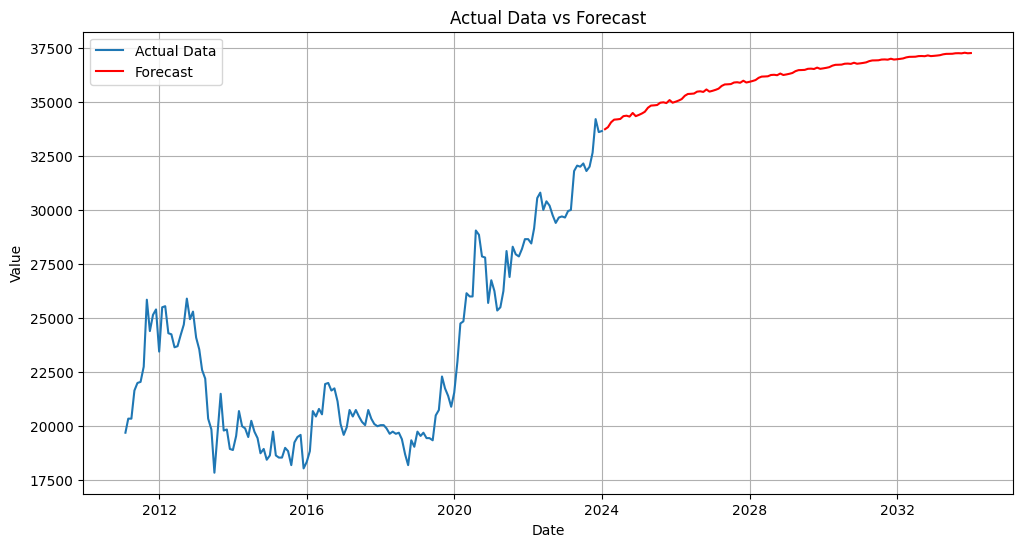

In [238]:
plt.figure(figsize=(12,6))
plt.plot(Gold_data['Report Date'] , Gold_data['GoldBar_Sale'] , label = 'Actual Data')
plt.plot(Date_forecast_period,preds , label='Forecast' , color = 'red')
# plt.fill_between(Date_forecast_period , conf_int[:,0],conf_int[:,1] , color='pink' , alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual Data vs Forecast')
plt.legend()
plt.grid(True)
plt.show()